## Binary clasification using a Sigmoid (logistic) Regression curve in the Scikit library
* Output of sigmoid function is 0 or 1 
* φ(z)  = 1/ 1 + e^-z
* linear regression model was y = b0 + b1x 
* logistic model is  p = 1/ 1+e^-(b0+b1x)
* use 50% as cutoff

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
sns.set_context("notebook")

In [13]:
train = pd.read_csv('titanic_train.csv')

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Quick Visual Exploratory analysis of the data

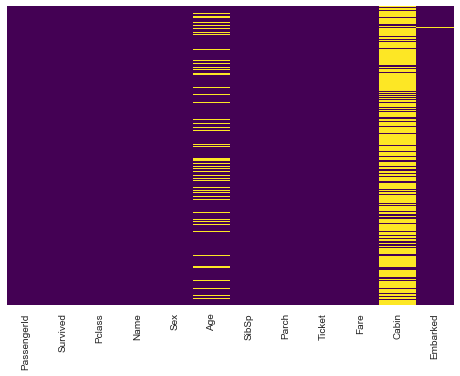

In [4]:
# highlight null values in data; age is small enough I can imputate it. 
# Cabin is missing too much data I may drop or create a column with column data T,F
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [46]:
sns.set_style('whitegrid')

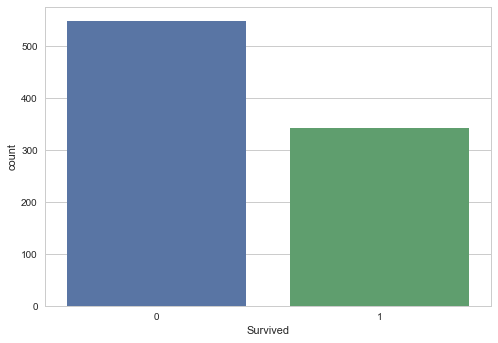

In [6]:
sns.countplot(x='Survived', data=train);

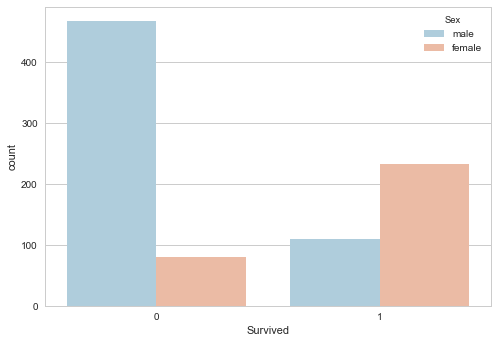

In [7]:
sns.countplot(x='Survived', data=train, hue='Sex', palette='RdBu_r');

0 = notsurvived; 1 = survived. Looking at this data by sex we can see that more female passengers survived.

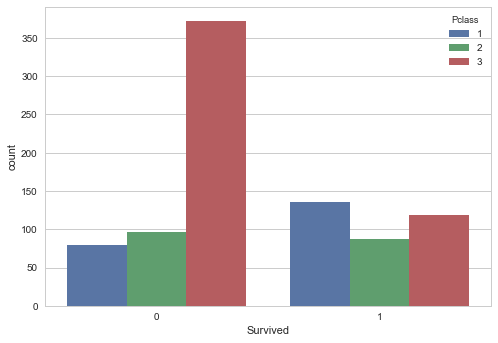

In [8]:
sns.countplot(x='Survived', data=train, hue='Pclass');

plotting the passengers and survival rates by class you can see that the pclass 3 or lower cost tickets high much higher death rates


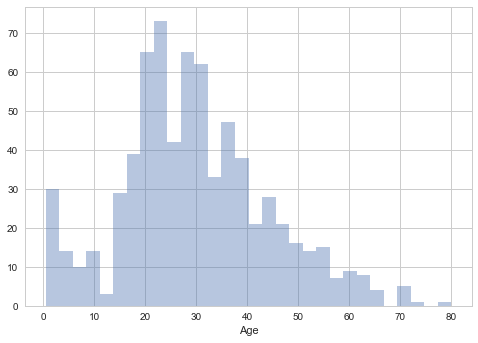

In [9]:
sns.distplot(train['Age'].dropna(), kde=False, bins=30);

Plotting all of the passengers by age you can see the distribution can be considered slightly binomial; We have a group of children, not many teenagers and most passengers are between the ages of 20 and 40.

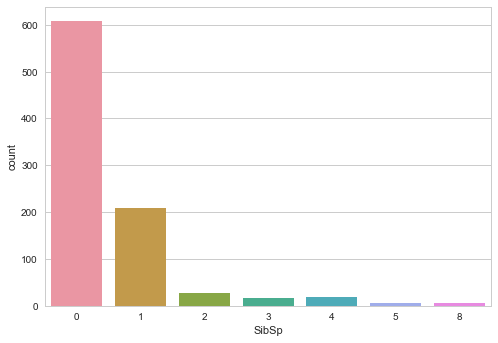

In [15]:
sns.countplot(x='SibSp',data=train)

Most of the passeners did not have a sibling or a spouse onboard.

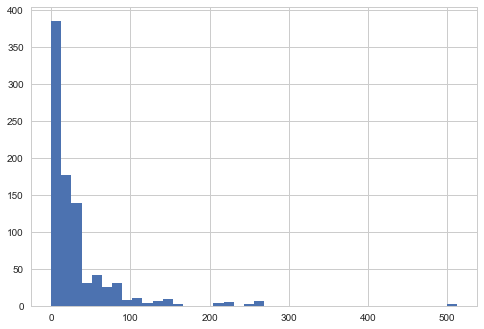

In [42]:
train['Fare'].hist(bins=40)

## Dealing with null values

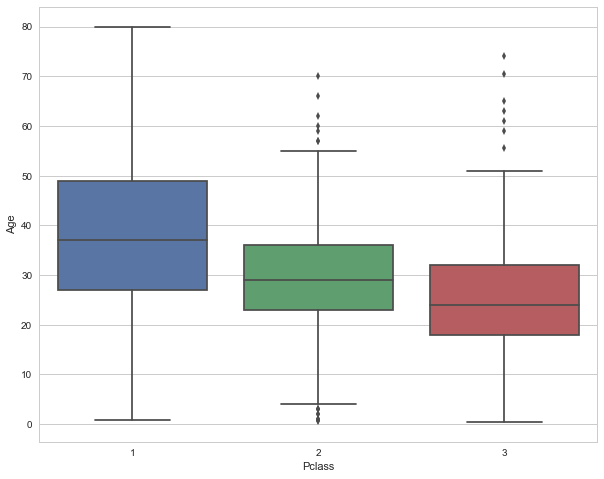

In [49]:
plt.figure(figsize=(10,8))
sns.boxplot(x='Pclass', y='Age', data=train);

The wealthier passengers are older in the 1st and 2nd class. I will impute based on the ages by class.

In [59]:
def impute_age(cols):
    Age = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):
        
        if Pclass == 1:
            #return mean of 1stclass
            return 37
        elif Pclass == 2:
            return 29
        else:
            return 24
    
    else:
        return Age
    
    

In [63]:
train['Age'] = train[['Age', 'Pclass']].apply(impute_age,axis=1)

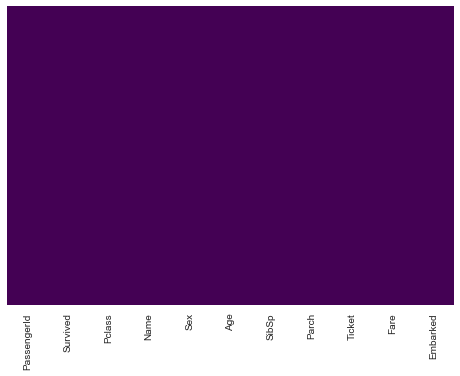

In [73]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis');

The heatmap now shows the imputed mean age function replaced all null values in age. Teh cabin column just has too many null values i will drop it.

In [69]:
train.drop('Cabin', axis=1,inplace=True)

In [74]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


In [72]:
train.dropna(inplace=True)
#drop any remaining nulls

Data is now clean. Now I will convert categorical features into dummy variables in order to apply logistic classification. For example sex column will be 0,1 value if they are male or not. Same for Embarked column. Note only one fo the dummy variables can be used in order to avoid multicollinearity where one column is the perfect predictor of another.

In [81]:
sex = pd.get_dummies(train['Sex'], drop_first = True)

In [83]:
embark = pd.get_dummies(train['Embarked'], drop_first = True)

In [85]:
train = pd.concat([train,sex,embark], axis=1)

In [86]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,male,Q,S
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,1,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,0,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,0,0,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,1,0,1


### Drop other columns I will not use including origin of dummy vars and non-numeric info. PassengerId is an unnecesary column.

In [88]:
train.drop(['Sex','Embarked','Name','Ticket'], axis=1,inplace=True)

In [90]:
train.drop('PassengerId', axis=1, inplace=True)

In [91]:
train.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,0,3,22.0,1,0,7.2500,1,0,1
1,1,1,38.0,1,0,71.2833,0,0,0
2,1,3,26.0,0,0,7.9250,0,0,1
3,1,1,35.0,1,0,53.1000,0,0,1
4,0,3,35.0,0,0,8.0500,1,0,1


## Note: I left Pclass as a categorical column instead of making it a dummy variable right away in order to test the effects on my machine learning algorithm.

# Logistic Regression Model Implementation

In [94]:
X = train.drop('Survived', axis=1)
y = train['Survived'] # what i am trying to predict

In [95]:
from sklearn.cross_validation import train_test_split

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [97]:
from sklearn.linear_model import LogisticRegression

In [98]:
logmodel = LogisticRegression()

In [99]:
logmodel.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [100]:
predictions = logmodel.predict(X_test)

In [101]:
from sklearn.metrics import classification_report

In [102]:
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

          0       0.80      0.91      0.85       163
          1       0.82      0.65      0.73       104

avg / total       0.81      0.81      0.80       267



In [103]:
from sklearn.metrics import confusion_matrix

In [104]:
print(confusion_matrix(y_test,predictions))

[[148  15]
 [ 36  68]]
